[0.00000000e+00 2.50050010e-05 5.00100020e-05 ... 1.24949990e-01
 1.24974995e-01 1.25000000e-01]


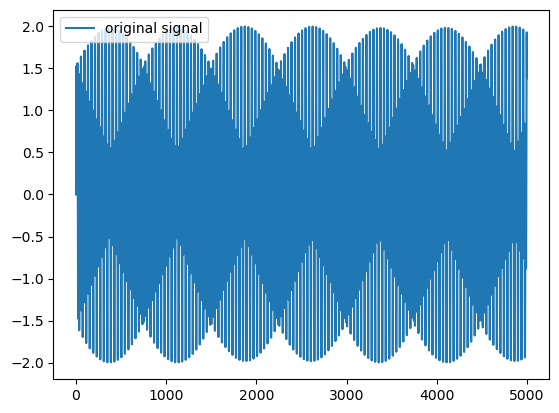

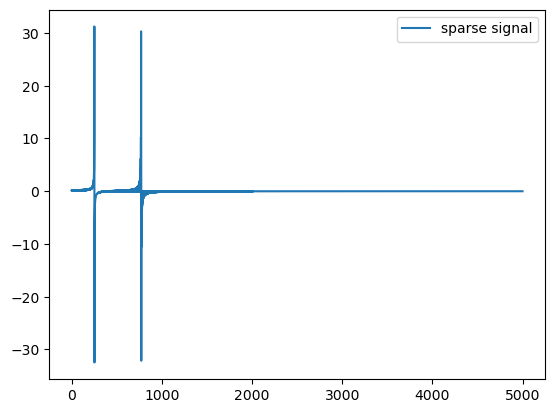

In [27]:
# make sure you've got the following packages installed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
#import cvxpy as cvx
np.random.seed(23)
# sum of two sinusoids
n = 5000
t = np.linspace(0, 1/8, n)
print(t)
#y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
y = np.sin(2020 * np.pi * t) + np.sin(6167 * np.pi * t)

yt = spfft.dct(y, norm='ortho')
plt.plot(y, label = "original signal")
#plt.scatter(range(len(yt)), yt, color='red', marker='o', label='Points')
plt.legend(loc='best')
plt.show()
plt.plot(yt, label = "sparse signal")
plt.legend(loc='best')
plt.show()

[  11   14   18   53   54  111  117  119  121  124  137  140  158  170
  185  189  217  218  224  232  241  242  268  270  279  284  287  293
  322  333  334  340  365  369  372  388  403  405  412  426  427  440
  453  454  459  465  476  482  483  487  509  516  522  534  540  542
  545  560  561  566  575  576  577  582  587  596  601  605  628  632
  633  648  649  663  673  681  692  702  707  714  724  739  744  758
  762  786  837  846  853  858  862  869  899  904  917  920  941  944
  945  955  958  959  985  988 1008 1014 1027 1028 1035 1039 1047 1059
 1061 1073 1086 1087 1097 1103 1107 1109 1131 1137 1141 1150 1151 1160
 1164 1185 1191 1200 1213 1214 1221 1245 1246 1253 1254 1277 1287 1334
 1341 1348 1371 1380 1395 1396 1408 1423 1429 1431 1432 1437 1468 1502
 1516 1528 1529 1536 1550 1553 1567 1598 1618 1629 1643 1653 1655 1665
 1672 1692 1703 1705 1717 1723 1731 1732 1733 1734 1741 1857 1877 1888
 1920 1924 1926 1933 1939 1967 1973 1974 1990 1992 1994 1999 2009 2013
 2018 

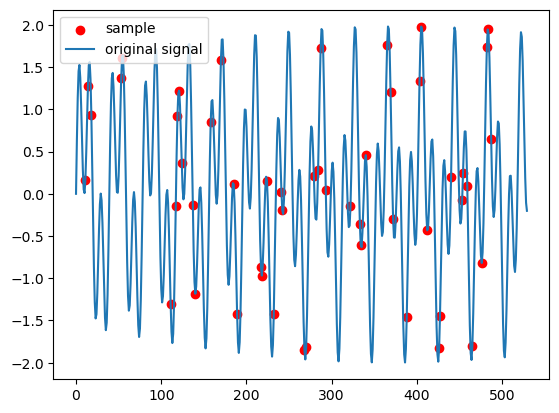

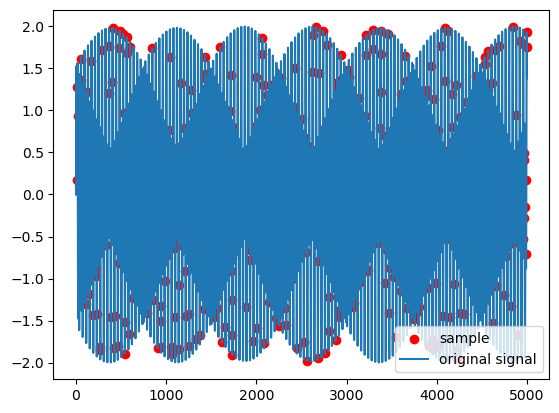

In [29]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]
print(ri)
print(y2)
plt.scatter(ri[0:50],y2[0:50], label = "sample",color = "red")
plt.plot(y[0:530], label = "original signal")
plt.legend(loc='best')
plt.show()
plt.scatter(ri,y2, label = "sample",color = "red")
plt.plot(y, label = "original signal")
plt.legend(loc='best')
plt.show()

In [39]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
print(A.shape)
A = A[ri]
print(A.shape)

# # do L1 optimization
# vx = cvx.Variable(n)
# objective = cvx.Minimize(cvx.norm(vx, 1))
# constraints = [A*vx == y2]
# prob = cvx.Problem(objective, constraints)
# result = prob.solve(verbose=True)

(5000, 5000)
(500, 5000)


In [31]:
n = len(A[0])
p = len(A)
b = y2.reshape((p,1))
#A = A.T
print(b.shape)
print(A)

(500, 1)
[[ 1.41421356e-02  1.99994779e-02  1.99979116e-02 ... -4.33505834e-04
  -2.89016464e-04 -1.44512005e-04]
 [ 1.41421356e-02  1.99991700e-02  1.99966800e-02 ...  5.46569065e-04
   3.64404582e-04  1.82209853e-04]
 [ 1.41421356e-02  1.99986489e-02  1.99945956e-02 ...  6.97292227e-04
   4.64913832e-04  2.32472621e-04]
 ...
 [ 1.41421356e-02 -1.99994779e-02  1.99979116e-02 ...  4.33505834e-04
  -2.89016464e-04  1.44512005e-04]
 [ 1.41421356e-02 -1.99999753e-02  1.99999013e-02 ... -9.42474308e-05
   6.28317497e-05 -3.14159136e-05]
 [ 1.41421356e-02 -1.99999911e-02  1.99999645e-02 ...  5.65485924e-05
  -3.76990895e-05  1.88495531e-05]]


In [32]:
lamda = 0.03
spectral_norm = np.linalg.norm(A.T @ A, ord=2)
print("Spectral Norm (2-Norm):", spectral_norm)
STEPSIZE  = 0.1/spectral_norm
EPSILON = pow(10,-8)
MAX_ITERATION = 10000
x0 = np.random.normal(size=n).reshape((n,1))


def check_size(x):
    if not(np.size(x,0)==np.size(A,1) and np.size(A,0) == np.size(b,0) and 
    np.size(x,1)== np.size(b,1) == 1):
        print("Size of problem do not match")
        print(np.size(x,0)==np.size(A,1) , np.size(A,0) == np.size(b,0) , 
    np.size(x,1)== np.size(b,1) == 1)
        print(x.shape,  np.size(b,1))
        exit()

def f(x):
    check_size(x)
    Ax_b = A.dot(x) - b
    return 0.5*(Ax_b.T.dot(Ax_b))

def gradient_f(x):
    check_size(x)
    Ax_b = A.dot(x) - b
    return A.T.dot(A.dot(x) - b)

def g(x):
    return lamda*np.sum(np.abs(x))

def F(x):
    return f(x) + g(x)

def prox(x,stepsize):
    if not(np.size(x,1)==1):
        exit()
    return np.sign(x)*np.maximum(np.zeros(np.shape(x)),np.abs(x)-stepsize*lamda)

def run_Proximal_Gradient():
    k = 0 # number of iterations
    stepsize = STEPSIZE
    x = x0.copy()
    x_old = x0.copy()
    objective_output = []

    while(k < MAX_ITERATION):
        x = prox(x_old - stepsize * gradient_f(x_old), stepsize)
        # print("\n----------------\n","x before gradient ",x_old.T)
        # print("x after gradient ",(x_old - stepsize * gradient_f(x_old)).T)
        # print("x after prox ",x.T)
        #if k % 1 ==0:
        #    print(k,":",x_old,"\n----------\n",x_old - stepsize * gradient_f(x_old) ,"\n----------\n",x)
        #if k == 100:
        #    exit()
        #if k % 200 == 0: print("k =",k," ---- error = ",np.linalg.norm(x - x_old))
        if np.linalg.norm(x - x_old) < EPSILON: 
            break
        objective_output.append((np.sum(F(x))))
        #objective_output.append((np.sum((F(x) + Fopt)/Fopt)))
        #objective_output.append(np.log(np.sum(F(x))))
        #objective_output.append(np.sum(np.abs(F(x) - Fopt)))
        #objective_output.append(np.linalg.norm((1 / stepsize)*(x - x_old),2))

        x_old = x.copy()
        k += 1
    print("num step of proximal : ",k)
    return x, objective_output

def run_FISTA():
    k = 0 # number of iterations
    stepsize = STEPSIZE
    x  = x0.copy()
    x_old = x0.copy()
    y = x.copy()
    t_old = 1
    objective_output = []
    while(k < MAX_ITERATION):
        x = prox(y - stepsize * gradient_f(y), stepsize)
        t = 0.5 + 0.5*np.sqrt(1+4*t_old*t_old)
        #print("Objective value: ",F(x),"----------", F(y - stepsize * gradient_f(y)))
        #print(k,":",x_old,"\n----------\n",y,"\n----------\n" ,y - stepsize * gradient_f(y),"\n----------\n",x)
        #if k == 50:break
        y = x + ((t_old-1)/(t))*(x - x_old)
        #if k % 1 ==0:
        #   print(k,":",x_old,"\n----------\n",y ,"\n----------\n",x)
        #if k == 100:
        #   exit()
        #if k % 20 == 0:print("x = ",x,"F(x) =",F(x),"Compare to Fopt",Fopt)
        if np.linalg.norm(x - x_old) < EPSILON: 
            break
        objective_output.append((np.sum(F(x))))
        #objective_output.append((np.sum((F(x) + Fopt)/Fopt)))
        #objective_output.append(np.log(np.sum(F(x))))
        #objective_output.append(np.sum(np.abs(F(x) - Fopt)))
        # objective_output.append(np.linalg.norm((1 / stepsize)*(x - x_old),2))

        x_old = x.copy()
        t_old = t
        k += 1
    print("num step of FISTA : ",k)
    return x, objective_output

Spectral Norm (2-Norm): 1.0000000000000018


num step of FISTA :  10000


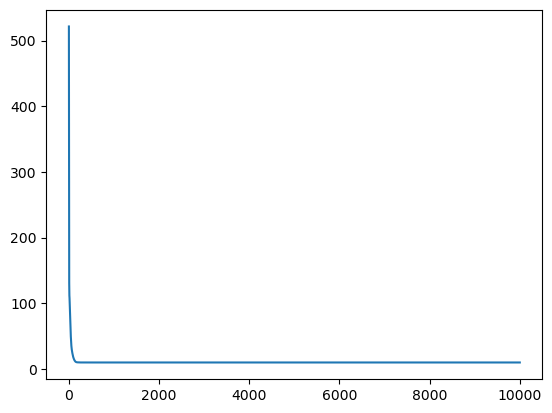

In [33]:
# reconstruct signal
x,F_values = run_FISTA()
x = np.squeeze(x)
plt.plot(F_values,label = "FISTA")
plt.show()

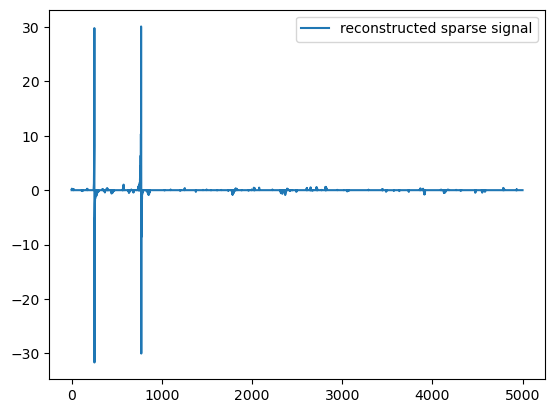

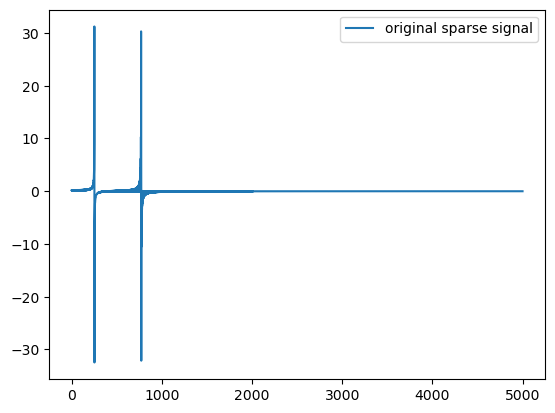

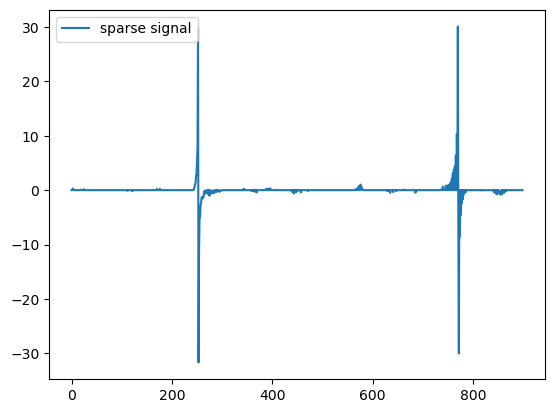

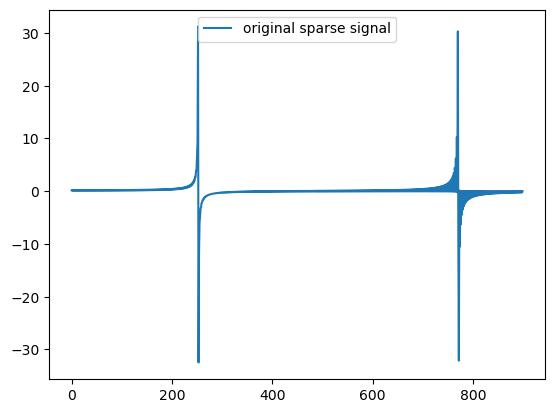

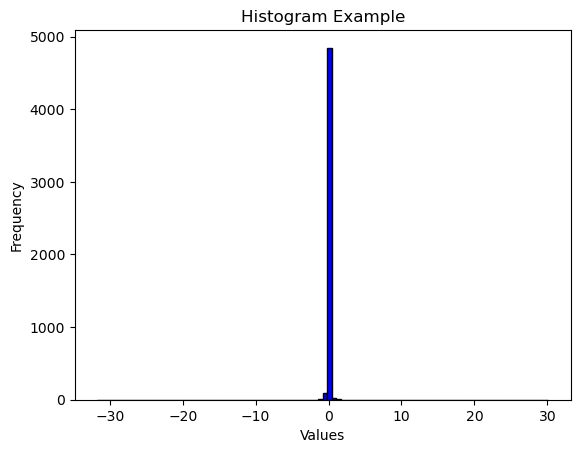

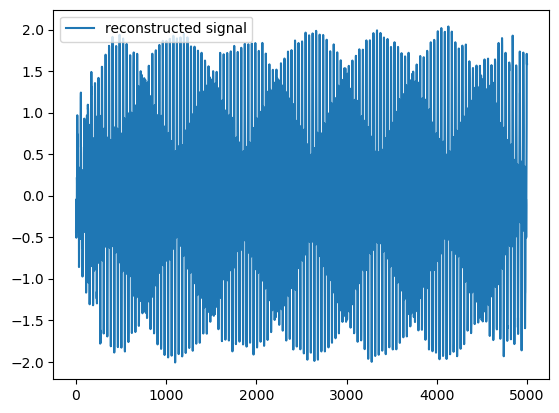

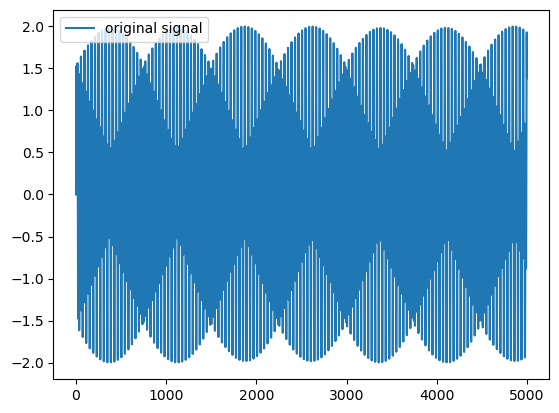

In [40]:

plt.plot(x, label = "reconstructed sparse signal")
plt.legend(loc='best')
plt.show()

plt.plot(yt, label = "original sparse signal")
plt.legend(loc='best')
plt.show()

plt.plot(x[0:900], label = "sparse signal")
plt.legend(loc='best')
plt.show()

plt.plot(yt[0:900], label = "original sparse signal")
plt.legend(loc='best')
plt.show()

plt.hist(x, bins=100, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Display the histogram
plt.show()

sig = spfft.idct(x, norm='ortho', axis=0)
plt.plot(sig, label = "reconstructed signal")
plt.legend(loc='best')
plt.show()
plt.plot(y, label = "original signal")
plt.legend(loc='best')
plt.show()

c:\Users\DUY THÁI\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


(2048, 1365, 3)
(2048, 1365)
(102, 68)
[[1.         0.57986409 0.24469725 ... 0.24469725 0.57986409 1.        ]
 [1.         0.57986409 0.24469725 ... 0.24469725 0.57986409 1.        ]
 [1.         0.57986409 0.24469725 ... 0.24469725 0.57986409 1.        ]
 ...
 [1.         0.57986409 0.24469725 ... 0.24469725 0.57986409 1.        ]
 [1.         0.57986409 0.24469725 ... 0.24469725 0.57986409 1.        ]
 [1.         0.57986409 0.24469725 ... 0.24469725 0.57986409 1.        ]]


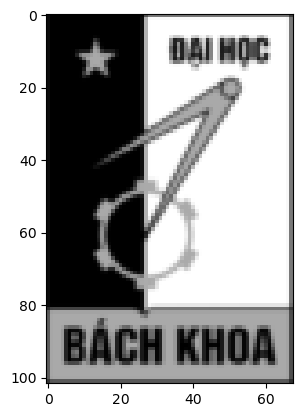

In [41]:
from skimage import io, color, transform
import matplotlib.pyplot as plt

# Read the RGB image using scikit-image
image_path = 'Logo_BK.png'  # Replace with the path to your RGB image file
rgb_image = color.rgba2rgb(io.imread(image_path))
print(rgb_image.shape)
gray_image = color.rgb2gray(rgb_image)
print(gray_image.shape)
resized_image = transform.rescale(gray_image, 0.05, anti_aliasing=True)
# Convert the RGB image to grayscale
print(resized_image.shape)
print(gray_image)
plt.imshow(resized_image, cmap='gray')
#plt.axis('off')  # Turn off axis labels
plt.show()

(563, 1000)
(56, 100)
[[0.35260667 0.36829294 0.37136627 ... 0.80174196 0.97821255 0.995     ]
 [0.25456745 0.24615882 0.29125333 ... 0.86448706 0.97821255 0.96280902]
 [0.26940549 0.25203765 0.30637412 ... 0.78213412 0.80566353 0.75104431]
 ...
 [0.63105137 0.64281608 0.64281608 ... 0.75263569 0.75263569 0.75263569]
 [0.68203176 0.68595333 0.68203176 ... 0.75263569 0.75263569 0.75263569]
 [0.68203176 0.68595333 0.68203176 ... 0.75263569 0.75263569 0.75263569]]


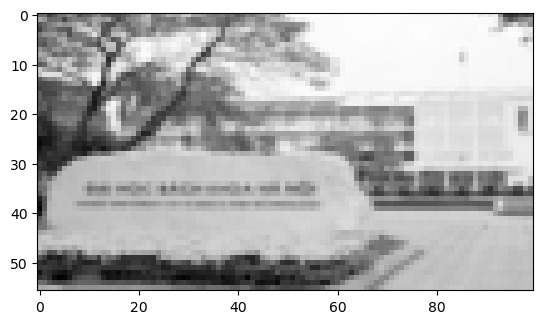

In [13]:
from skimage import io, color, transform
import matplotlib.pyplot as plt

# Read the RGB image using scikit-image
image_path = 'BK.jpg'  # Replace with the path to your RGB image file
gray_image = color.rgb2gray(io.imread(image_path))
print(gray_image.shape)
resized_image = transform.rescale(gray_image, 0.1, anti_aliasing=True)
# Convert the RGB image to grayscale
print(resized_image.shape)
print(gray_image)
plt.imshow(resized_image, cmap='gray')
#plt.axis('off')  # Turn off axis labels
plt.show()

[   0    1    5 ... 6928 6930 6934]


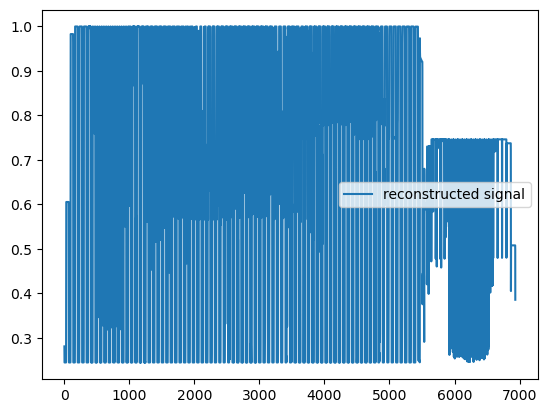

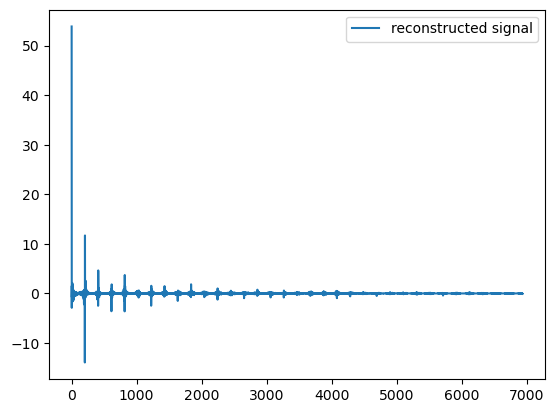

[[-53.59238375]
 [  0.32473326]
 [  3.14417219]
 ...
 [  0.5181172 ]
 [  0.54477325]
 [  0.44601892]]


In [42]:
height, width = resized_image.shape
flatten_Image = resized_image.reshape((height*width, 1)).astype(float)
ri = np.random.choice(height*width, int(0.5*height*width), replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
print(ri)
sample_Img = flatten_Image[ri]
# print(sample_Img)
# print(sample_Img.shape)
sparse_img = spfft.dct(flatten_Image, norm='ortho',axis=0) 
plt.plot(flatten_Image, label = "reconstructed signal")
plt.legend(loc='best')
plt.show()
plt.plot(sparse_img, label = "reconstructed signal")
plt.legend(loc='best')
plt.show()
print(flatten_Image - sparse_img)

In [43]:
A = spfft.idct(np.identity(height*width), norm='ortho', axis=0)
A = A[ri]

n = len(A[0])
p = len(A)
b = sample_Img
#A = A.T
print(b.shape)
print(A.shape)
x0 = np.random.normal(size=n).reshape((n,1))

(3468, 1)
(3468, 6936)


num step of FISTA :  4423


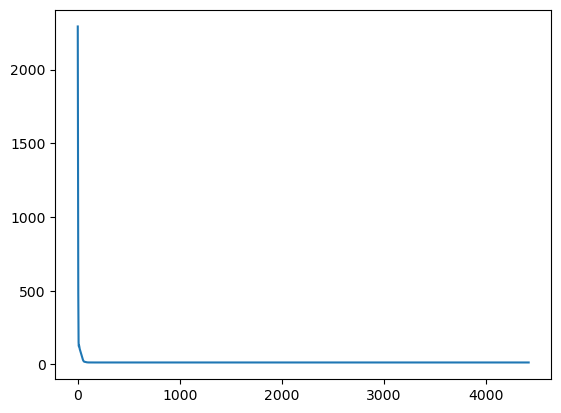

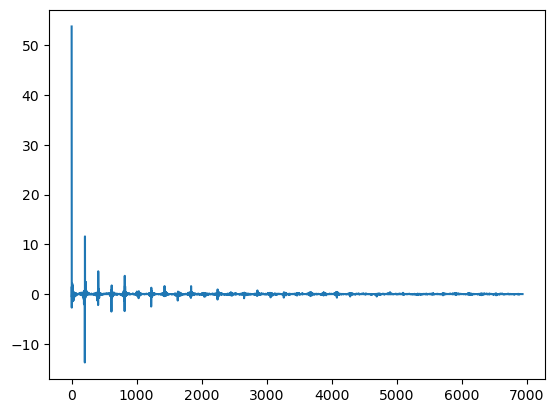

In [44]:
# reconstruct signal
x,F_values = run_FISTA()
x = np.squeeze(x)
plt.plot(F_values,label = "FISTA")
plt.show()
plt.plot(x,label = "FISTA")
plt.show()

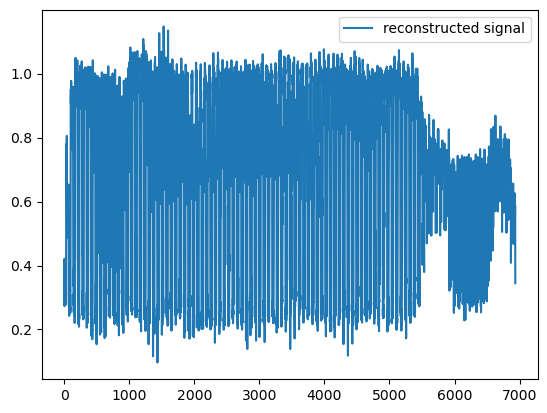

In [45]:
sig = spfft.idct(x, norm='ortho', axis=0)
plt.plot(sig, label = "reconstructed signal")
plt.legend(loc='best')
plt.show()

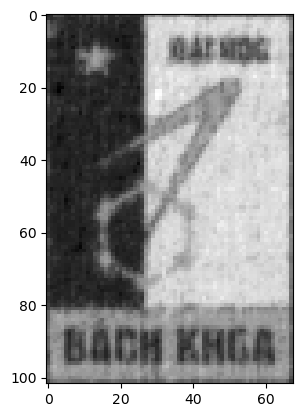

In [46]:
restruct_Img = sig.reshape((height,width))
plt.imshow(restruct_Img, cmap='gray')
#plt.axis('off')  # Turn off axis labels
plt.show()